# Chapter 3 - Mikkel Werling

In [1]:
import numpy as np 
from scipy import stats
import pymc3 as pm
import arviz as az
import theano
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Let's make a generic data-set, with a predetermined linear relation ($y = \alpha + \beta * x$) and added noise ($\epsilon$)

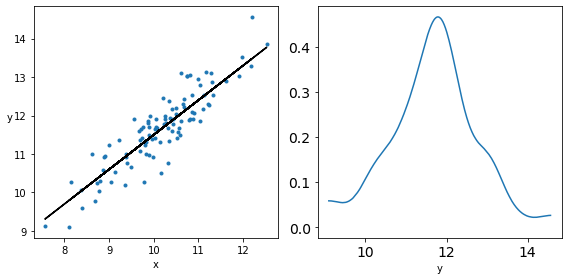

In [10]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

y = y_real + eps_real
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

Now to model this with $pyMC3$. Nothing new here. Only difference is the addition of the mathematical formula by which we want y to be predicted from. We encode this by using $pm.Deterministic(formula)$ like so:

In [11]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x) #NOTE THE CHANGE!!!
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164597467916465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


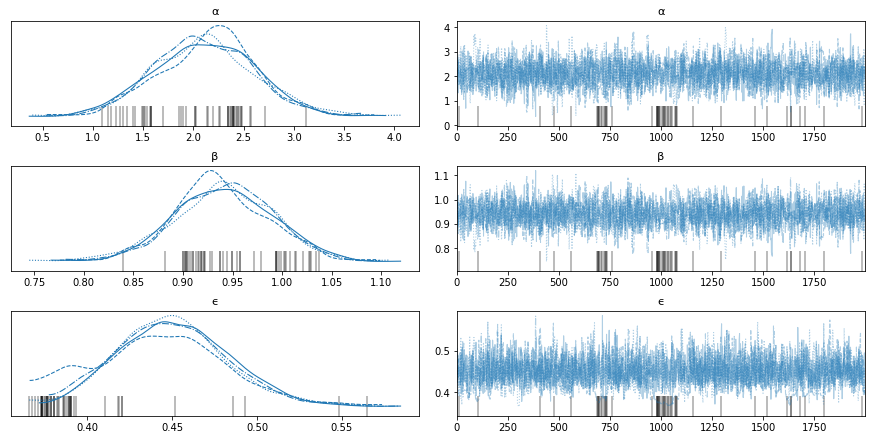

In [12]:
with model_g:
    az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


<AxesSubplot:xlabel='α', ylabel='β'>

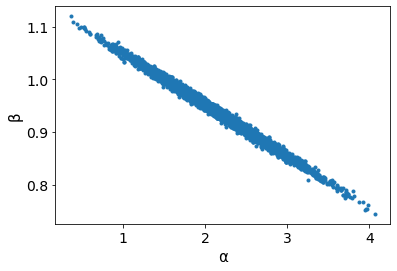

In [13]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

### NOTE:
The above correlation is not the correlation with x and y, but with the $\beta$ and $\alpha$ parameter! We are forcing the slope of the line to go through the mean, and therefore the slope and the intercepts move together. 

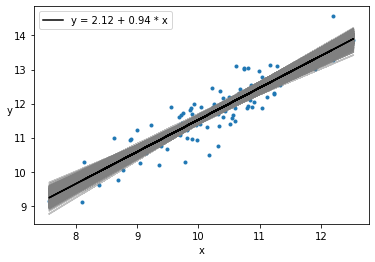

In [14]:
plt.plot(x, y, 'C0.')
alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws] * x[:, np.newaxis], c='gray', alpha=0.5)
plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

Using the $HPD$ as our marked area instead (that was one of the main points of using the deterministic evaluation in the first place)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


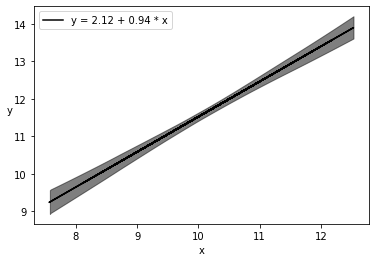

In [15]:
plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='k')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

Following Rethinking functions and overall presentations, we would like there to be two different $HDP$s - one displaying 94% and one displaying 50%:

In [16]:
ppc = pm.sample_posterior_predictive(trace_g,
                               samples = 2000,
                               model = model_g)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


Text(0, 0.5, 'y')

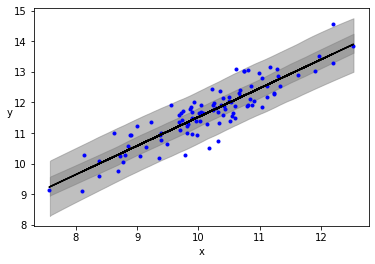

In [17]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray')
az.plot_hpd(x, ppc['y_pred'], color='gray')
plt.xlabel('x')
plt.ylabel('y', rotation=0)

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


Text(0, 0.5, 'y')

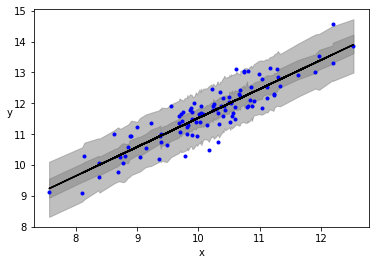

In [18]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray', smooth = False) #NOTE SMOOTH
az.plot_hpd(x, ppc['y_pred'], color='gray', smooth = False) #NOTE SMOOTH
plt.xlabel('x')
plt.ylabel('y', rotation=0)

We can calculate how well our model performs ($R^2$) using our samples and our real values

In [19]:
az.r2_score(y, ppc['y_pred']) #calculating R^2 by taking out the predictions using our ppc

r2        0.786460
r2_std    0.006192
dtype: float64

Calculating bivariate Gaussian distributions and their Pearson correlations:

Text(-0.05, 0.5, 'x_2')

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

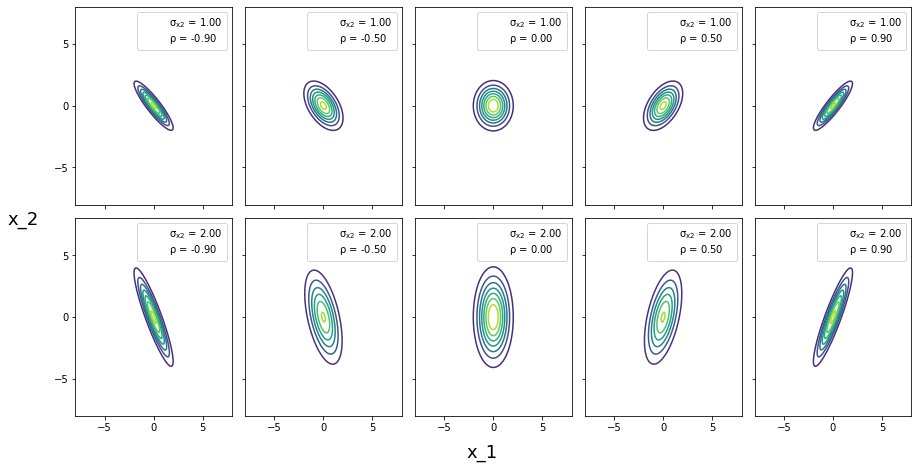

In [21]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]
k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l
f, ax = plt.subplots(len(sigmas_x2), len(rhos),
sharex=True, sharey=True, figsize=(12, 6),
constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
        [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
        label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

Instead of using the premade functions, we can also be just absolute monsters and make a model that estimates it for us for no apparent reason:

In [23]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:
    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)
    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)
    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ], [σ_1*σ_2*ρ, σ_2**2]))
    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

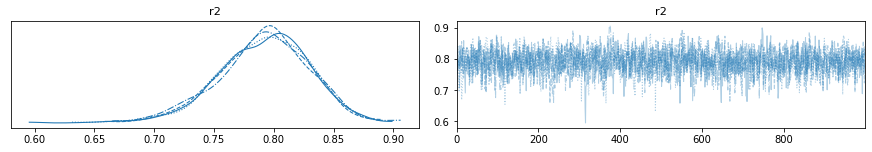

In [24]:
az.plot_trace(trace_p, var_names=['r2'])

In [25]:
az.summary(trace_p, var_names=['r2'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
r2  0.792  0.038   0.718    0.858      0.001    0.001    1945.0  1925.0   

    ess_bulk  ess_tail  r_hat  
r2    1903.0    2060.0    1.0

So overall take-aways?:

We did good! It matches quite well *the fucking function that just does this for you without the crazy omega-model*. But it proves the point I guess - this method is crazy general. 

## New day, New data

Import some new data, and we centralize everything

In [28]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

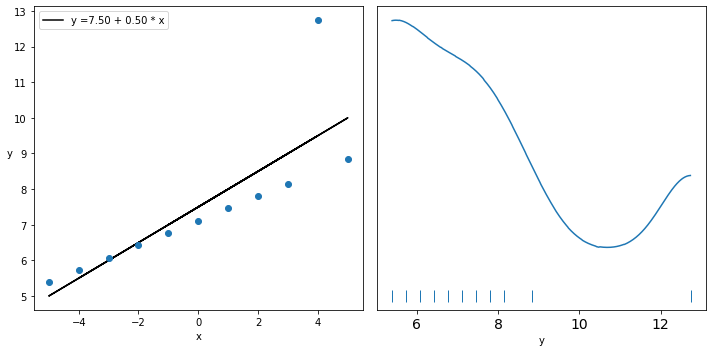

In [29]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

So the whole point here is that we have a *very* clear linear relationship, but an outlier is skewing the relationship heavily. Maybe we can fix this with using the Student T distribution like we always fix things with? 

In [30]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1) # shifting v to avoid too many values close to 0 as we have a crazy outlier
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
    sd=ϵ, nu=ν, observed=y_3)
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
The number of effective samples is smaller than 25% for some parameters.


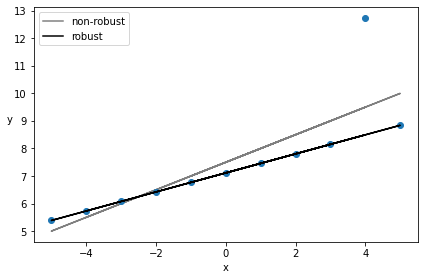

In [31]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

#### Take aways

Here we are seeing the difference between your normal (non-robust) and the robust regression. By using the Student T Distribution, we are giving our model the liberty of discarding data points that are clear outliers, which gets us closer to the underlying mechanism that seems to be driving the correlation for almost all participants. 

In [34]:
az.summary(trace_t, var_names=["α", "β", "ν", "ϵ"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α  7.114  0.001   7.111    7.117      0.000    0.000    3754.0  3754.0   
β  0.345  0.000   0.345    0.346      0.000    0.000    3591.0  3591.0   
ν  1.207  0.205   1.000    1.567      0.003    0.002    5309.0  5309.0   
ϵ  0.003  0.002   0.001    0.006      0.000    0.000    1988.0  1988.0   

   ess_bulk  ess_tail  r_hat  
α    4093.0    3653.0    1.0  
β    3759.0    3488.0    1.0  
ν    3006.0    1965.0    1.0  
ϵ    1070.0     393.0    1.0

So the values are scaled, to $\alpha$ is the mean of $y$. $\beta$ is the standardized change for the values. $v$ is the normality parameter that we pushed away from 0. $\epsilon$ is how uncertain we are about the linear regression (the standard deviation). We can see from the plot, that is a GREAT fit, and we should therefore not be so surprised that it is very low. Let's look at the posterior:

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(0.0, 12.0)

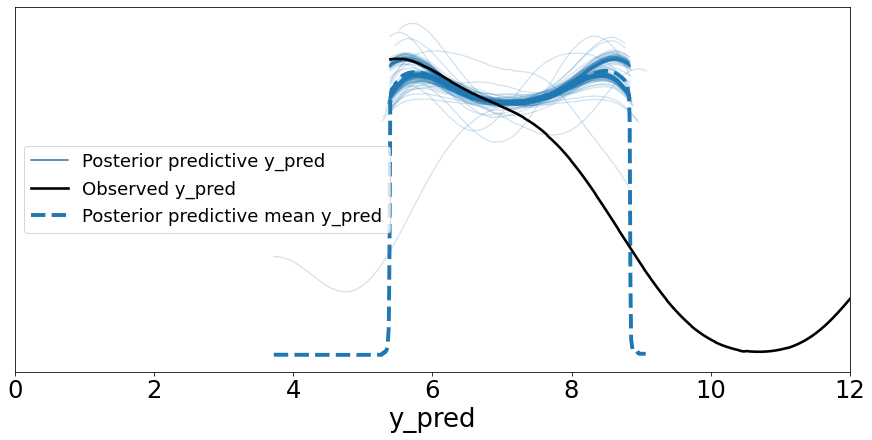

In [35]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t,
random_seed=2)
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)

Notice that for the most part, this is actually a good model, even if it doesn't look that way. We are getting quite close to the *actual* mean of the distribution if we exclude the outlier. But obviously for more complex problems, this will be a problematic model.

## Hierachical Linear Models
Let's first make some data and fit some hierachical linear models to it. 

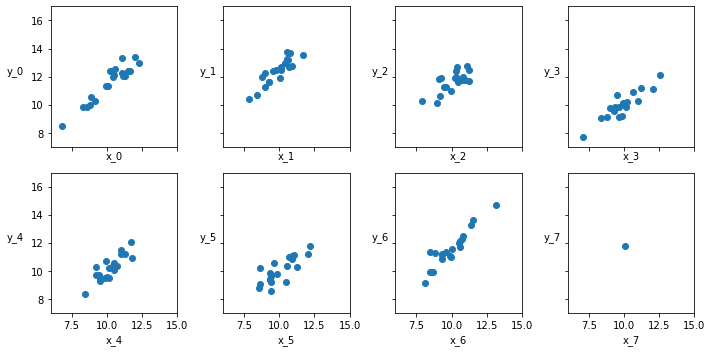

In [36]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

Let's start off with centering the data:

In [37]:
x_centered = x_m - x_m.mean()

First, let's just make a non-hierachical model, but with the inclusion of getting $\alpha$ back to its original interpretation:

In [38]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
    sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean()) #recalculating alpha to get back 
    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Perfect, we are geniuses right? Let's just plot it and be done with it. Wait, it said it has divergences? What could have possibly gone wrong?! 

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

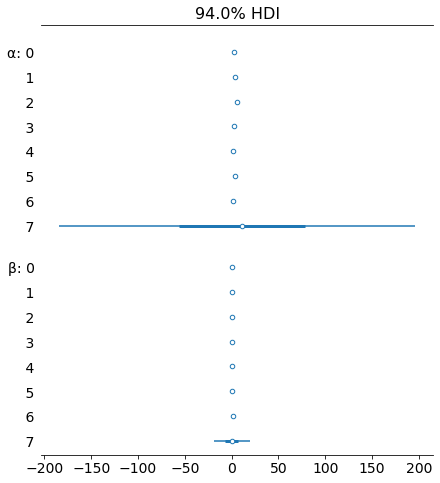

In [39]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)

We are idiots. The 7th group has only one data-point, and therefore we can fit **any** beta and corresponding alpha value to pass through that point. We can circumvent this problem by having much stronger priors. Another way is to make hierachical models, so that the information found in more reliable groups can be used to estimate in the groups with less information.

So now, let's implement a hierachical model and just visualize it's DAG before going any further:

In [40]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)
    
    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred',
    mu=α_tmp[idx] + β[idx] * x_centered,
    sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

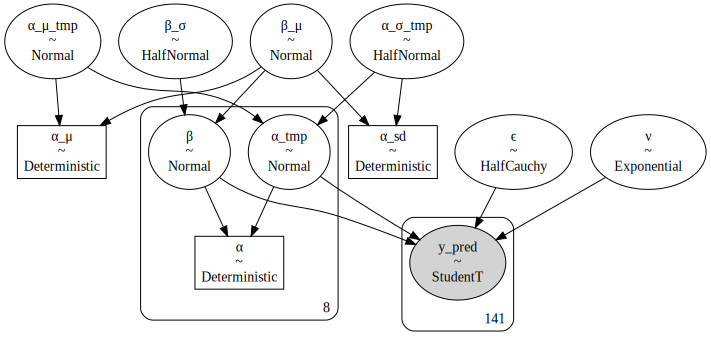

In [42]:
pm.model_to_graphviz(hierarchical_model)

In [43]:
with hierarchical_model:
    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.540988276553885, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Let's see if that helped at all. We still get some pretty heavy divergences. We'll make the same forest plot as before. If it helped we would hope that the x-axis has shrunked a lot, and that the problem group now gets reasonable parameters.

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

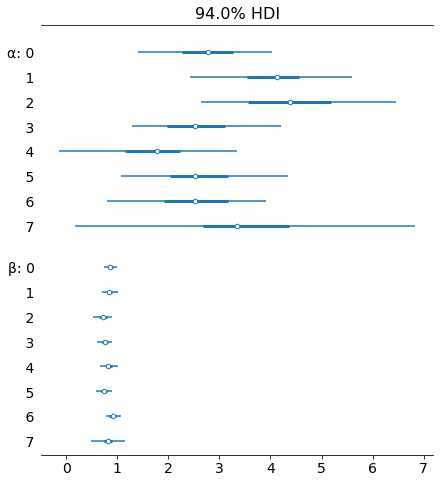

In [44]:
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

So if we ignore the divergences for now, we can see that this is a far better way to handle the lack of information in the 7th group. 

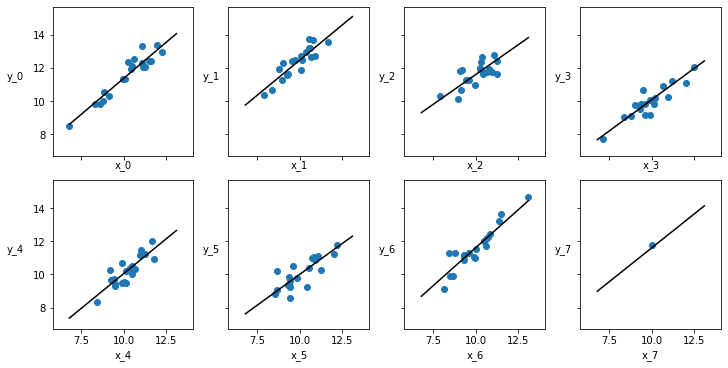

In [45]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

## Moving on up - Polynomial regression

Text(0, 0.5, 'y')

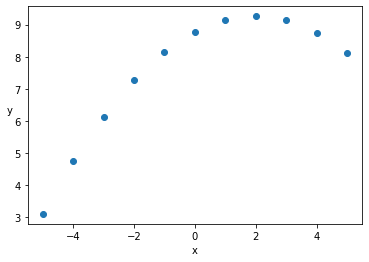

In [46]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [47]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_2 + β2 * x_2**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


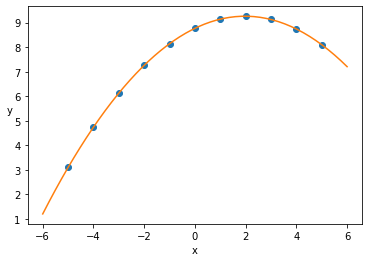

In [51]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

## Multiple Regression Model 

In [52]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1,
1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

Finally, let's have a more functional approach to all this madness. We define scatter_plot as a convenient function for plotting that will be used several times throughout this chapter

In [128]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

In [129]:
scatter_plot(X_centered, y)

NameError: name 'X_centered' is not defined

In [56]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α_tmp + pm.math.dot(X_centered, β) #as we now are dealing with a vector, we take the dot product
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


In [57]:
varnames = ['α', 'β', 'ϵ']
az.summary(trace_mlr, var_names=varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
α[0]  1.850  0.457   1.054    2.744      0.004    0.003   11425.0  10930.0   
β[0]  0.969  0.044   0.888    1.050      0.000    0.000   11577.0  11510.0   
β[1]  1.470  0.032   1.413    1.533      0.000    0.000   13054.0  13054.0   
ϵ     0.473  0.035   0.411    0.541      0.000    0.000   12119.0  11914.0   

      ess_bulk  ess_tail  r_hat  
α[0]   11448.0    6021.0    1.0  
β[0]   11602.0    5830.0    1.0  
β[1]   13165.0    6363.0    1.0  
ϵ      12149.0    5931.0    1.0

## Confounding variables

In [58]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

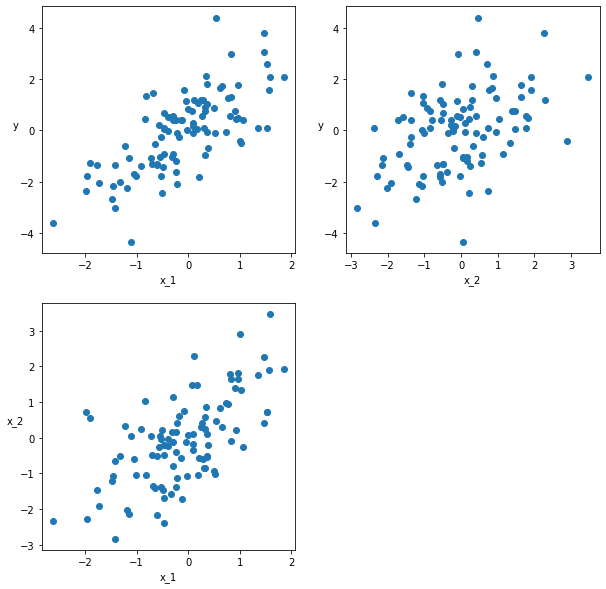

In [59]:
scatter_plot(X, y)

Alrightio, here we go: We are going to build a shitton of models and see what goes wrong:

In [60]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1x2 = pm.sample(2000)
    
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

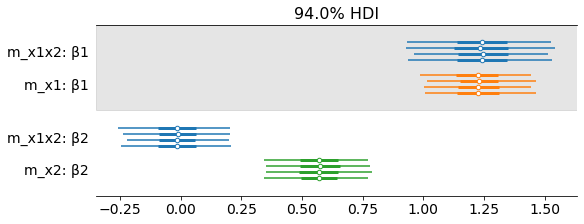

In [61]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))

### Take away
The problem is a known one. When the variance explained by one variable is included, the effect of the others dissapear. 

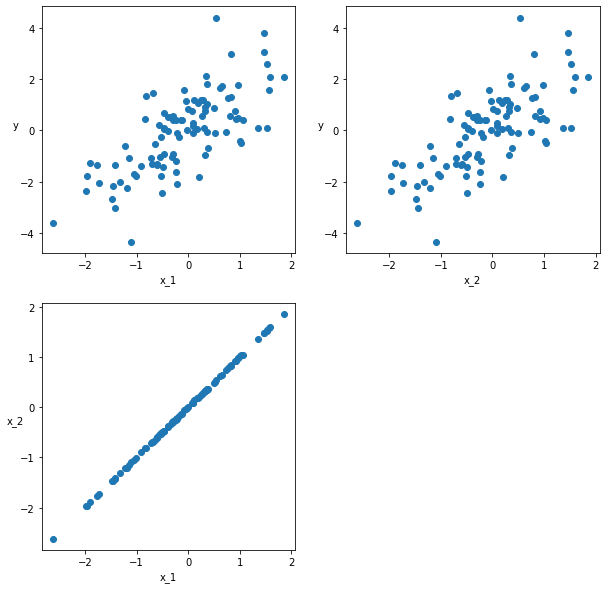

In [62]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

scatter_plot(X, y)

It should be pretty clear that the final plot suggests a *perfect* relationship between the two variables. Does this reflect in the model? Or will collinearity become an issue? Find out in the next cell!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 117 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8834611279805336, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

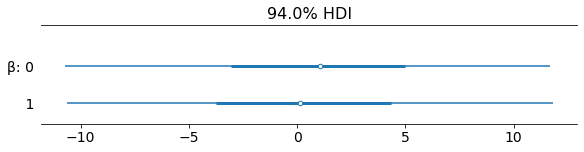

In [63]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + pm.math.dot(X, β)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_red = pm.sample(2000)

az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8,
2))

<AxesSubplot:xlabel='β\n0', ylabel='β\n1'>

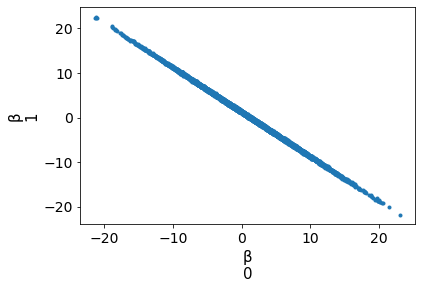

In [64]:
az.plot_pair(trace_red, var_names=['β'])

## Masking effects

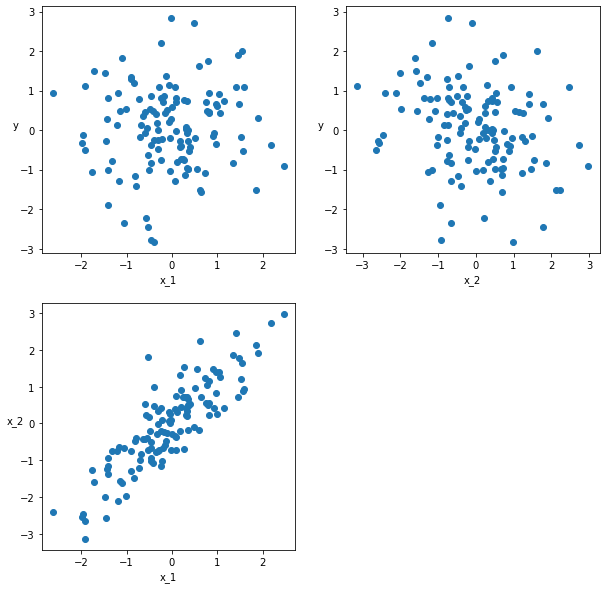

In [65]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

Running the models again for the new variables. What should we expect? Well, a good suggestion is probably the effects of each individual contribution can be unraveled. In isolation, they won't illuminate the effect. 

In [66]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1x2 = pm.sample(2000)
    
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.8845999195901234, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

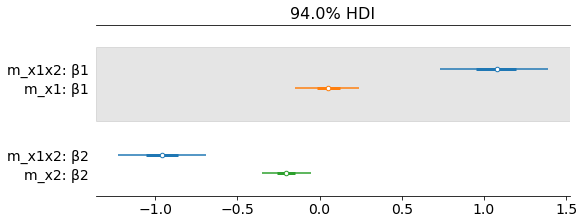

In [67]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

## The variability of variable variance

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

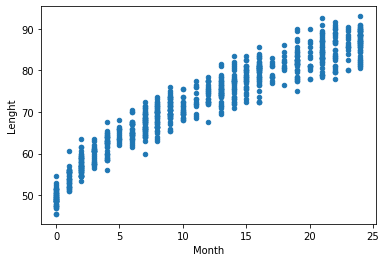

In [84]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')

We are now trying to model the variance as well as a function of x. It's quite crazy:

In [98]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)
    x_shared = theano.shared(data.Month.values * 1.)
    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)
    trace_vv = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


In [99]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [93]:
ref = 47.5
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()

AttributeError: module 'arviz' has no attribute '_fast_kde'

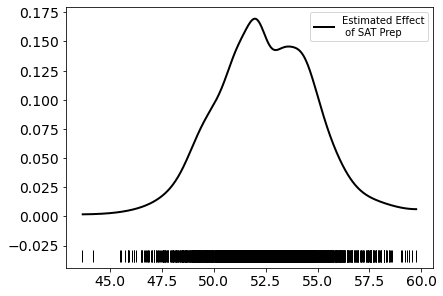

In [107]:
ax = az.plot_kde(
    y_ppc,
    label="Estimated Effect\n of SAT Prep",
    rug=True,
    plot_kwargs={"linewidth": 2, "color": "black"},
    rug_kwargs={"color": "black"},
    adaptive = True
)
plt.show()

DAMN IT! He used some funky function called "shared", which just means we have no idea what the hell is happening now.

FUTURE MIKKEL'S ASSESSMENT: Stupid past Mikkel. It's just a classic "Theano" variable, which is just amazing. 

# Exercises
## Exercise 1: What's Bayes got to do with it?

Check the following definition of a probabilistic model. Identify the likelihood,
the prior, and the posterior:

$$y_i \sim Normal(\mu, \sigma)$$
$$\mu \sim Normal(0, 10)$$
$$ \sigma \sim HalfNormal(25) $$

The first one is the likelihood (notice that it has no fixed parameters). The others are our priors (notice the fixed values). The posterior does not really make that much sense to talk about here. We will have posterior distributions for *all* of them. 

## Exercise 2: What is Bayes? Baby don't hurt me

For the model in exercise 1, how many parameters have the posterior? In other
words, how many dimensions does it have?

As we have two unknowns that we are trying to estimate (which the posterior for $y_i$ depends upon), we will have two dimensions.

## Exercise 3: Harry Potter and Bayes Theorem
Write down Bayes' theorem for the model in exercise 1.

Bayes Theorem is normally:

$$p(A|B) = \frac{p(B|A) \cdot p(A)}{p(B)}$$

so in our case:

$$p(Normal(\mu, \sigma)|y_i) = \frac{p(y_i|Normal(\mu, \sigma)) \cdot p(\mu)p(\sigma)}{p(y_i)}$$

## Exercise 4: Linear models and how to train them
Check the following model. Identify the linear model and identify the likelihood.
How many parameters does the posterior have?

$$y_i \sim Normal(\mu, \epsilon)$$
$$\mu = \alpha + \beta x $$
$$\alpha \sim Normal(0, 10)$$
$$\beta \sim Normal(0, 1)$$
$$\epsilon \sim HalfNormal(25)$$

The linear model is obviously number two. Notice that it is the only one that is deterministically defined. And because of that the posterior for $y$ will still only have 2 parameters. The rest are deterministically defined. 

# Exercise 5: 57 seconds to Mars

For the model in exercise 1, assume that you have a dataset with 57 data points
coming from a Gaussian with a mean of 4 and a standard deviation of 0.5. Using
PyMC3, compute:
- The posterior distribution
- The prior distribution
- The posterior predictive distribution
- The prior predictive distribution

Tip: Besides pm.sample(), PyMC3 has other functions to compute samples.

_____
So the model looks like:

$$y_i \sim Normal(\mu, \sigma)$$
$$\mu \sim Normal(0, 10)$$
$$ \sigma \sim HalfNormal(25) $$


In [70]:
data = np.random.normal(loc=4, scale=0.5, size=57) #get by a normal distribution

In [78]:
with pm.Model() as dumb_model:
    #priors
    mu = pm.Normal("mu", 0, 10)
    sigma = pm.HalfNormal("sigma", 25)
    
    #likelihood
    y = pm.Normal("y", mu, sigma, observed = data)
    
    #sample 
    trace = pm.sample(2000)
    prior_dist = pm.sample_prior_predictive(50)
    poster_dist = pm.sample_posterior_predictive(trace, 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

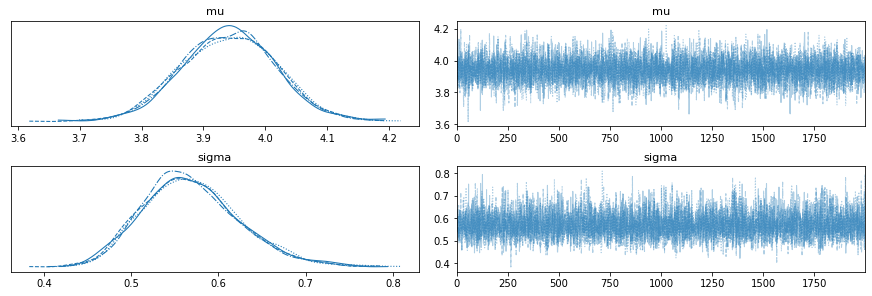

In [79]:
az.plot_trace(trace)

In [80]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu     3.941  0.077   3.797    4.083      0.001    0.001    6660.0  6660.0   
sigma  0.569  0.056   0.469    0.673      0.001    0.000    6984.0  6900.0   

       ess_bulk  ess_tail  r_hat  
mu       6665.0    5258.0    1.0  
sigma    7030.0    4955.0    1.0

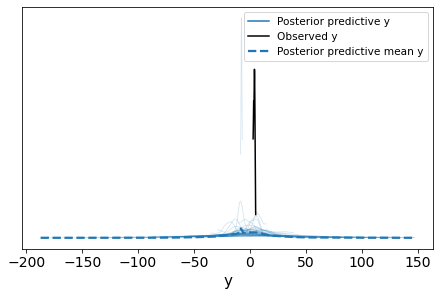

In [81]:
az.plot_ppc(az.from_pymc3(posterior_predictive=prior_dist, model=dumb_model));

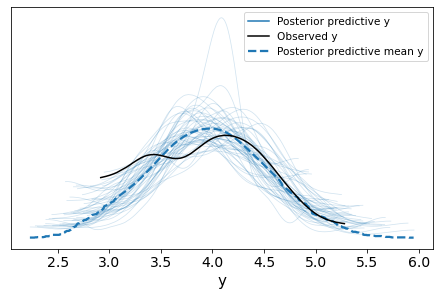

In [82]:
az.plot_ppc(az.from_pymc3(posterior_predictive=poster_dist, model=dumb_model));

## Exercise 6: Going NUTS!

1. Execute model_g using NUTS (the default sampler) and then using Metropolis. Compare the results using ArviZ functions like plot_trace and plot_pair. Center the variable x and repeat the exercise. What conclusion can you draw from this?

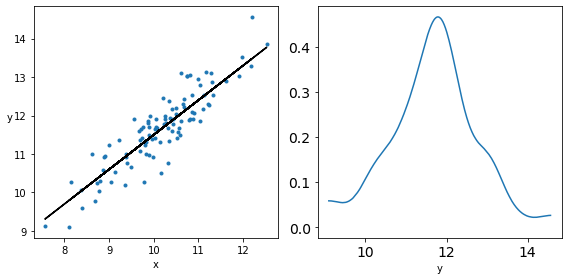

In [4]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

y = y_real + eps_real
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [5]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x) #NOTE THE CHANGE!!!
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    

In [8]:
with model_g:
    trace_nuts = pm.sample(2000, tune=1000)
    trace_metro = pm.sample(2000, tune=1000, step = pm.Metropolis())
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

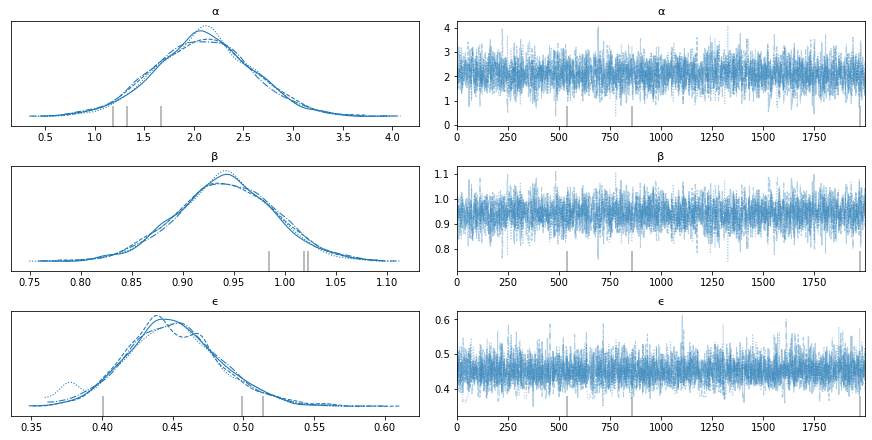

In [15]:
az.plot_trace(trace_nuts, var_names = ['α', 'β', 'ϵ'])

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

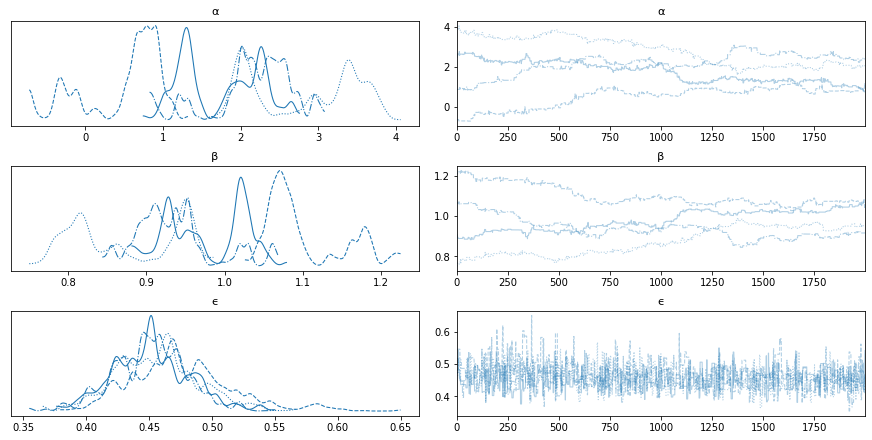

In [16]:
az.plot_trace(trace_metro, var_names = ['α', 'β', 'ϵ'])

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

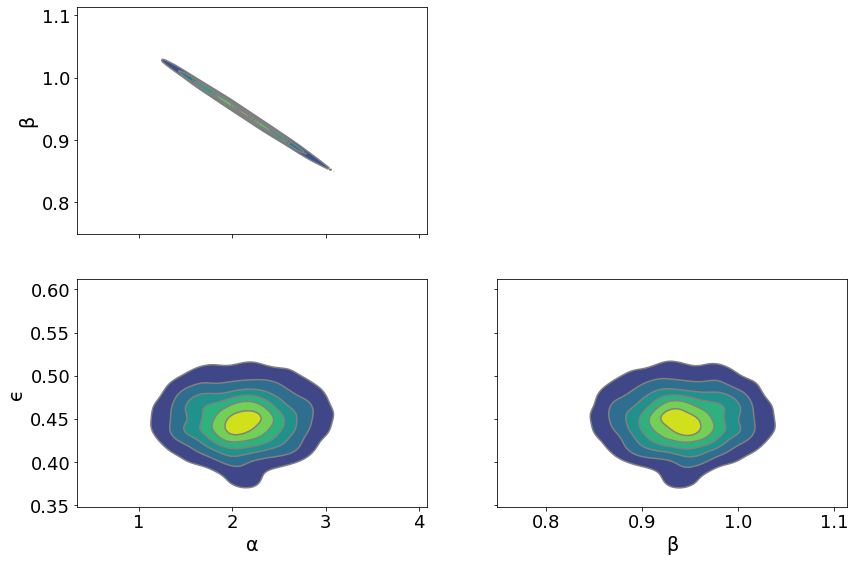

In [17]:
az.plot_pair(trace_nuts,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

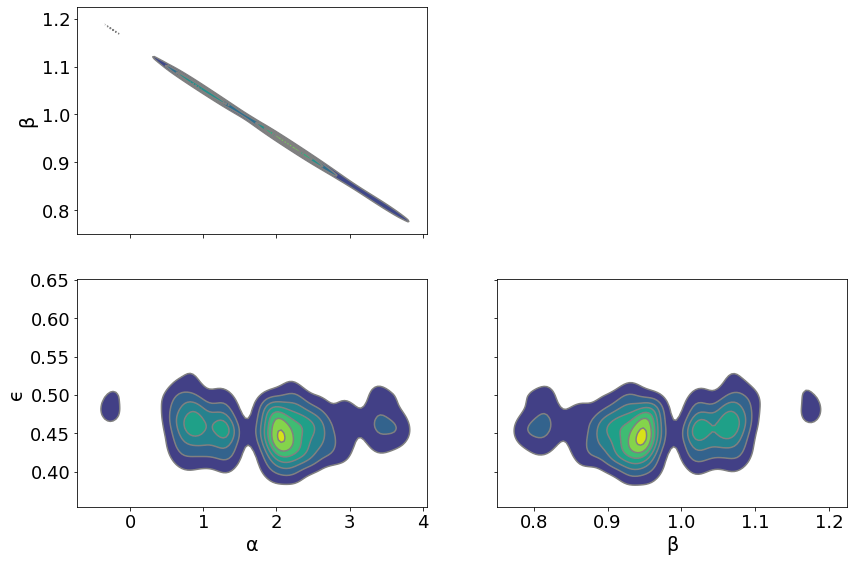

In [18]:
az.plot_pair(trace_metro,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

In [22]:
x_centered = x - np.mean(x)

In [23]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_centered) #NOTE THE CHANGE!!!
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    

In [24]:
with model_g:
    trace_nuts = pm.sample(2000, tune=1000)
    trace_metro = pm.sample(2000, tune=1000, step = pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

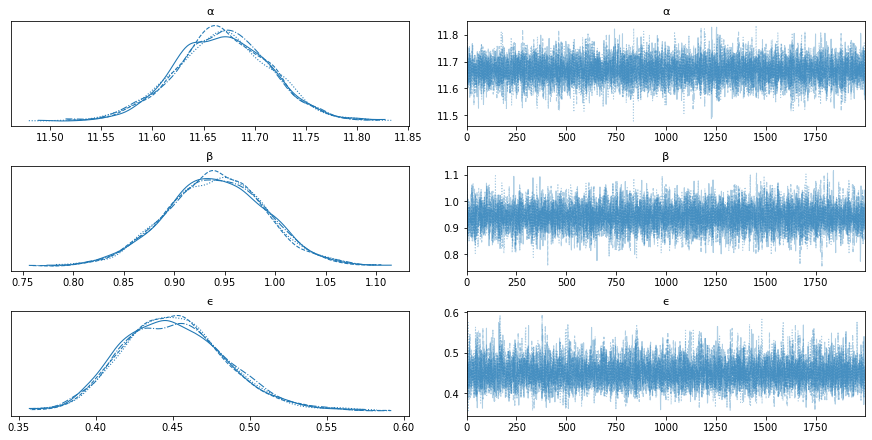

In [25]:
az.plot_trace(trace_nuts, var_names = ['α', 'β', 'ϵ'])

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

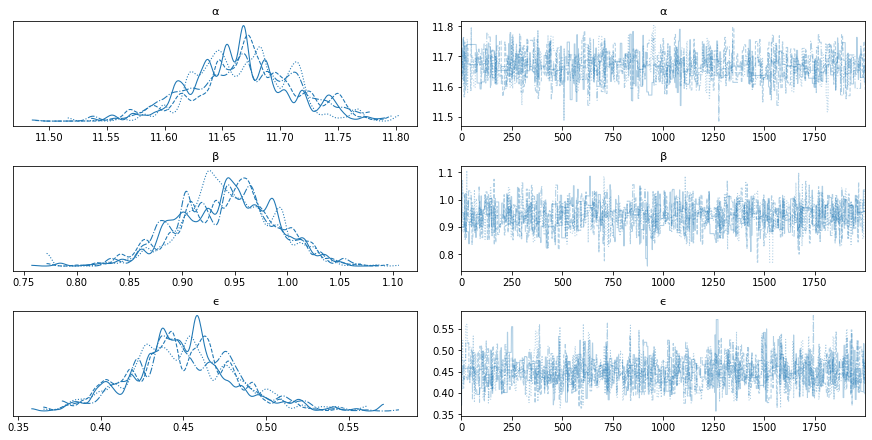

In [26]:
az.plot_trace(trace_metro, var_names = ['α', 'β', 'ϵ'])

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

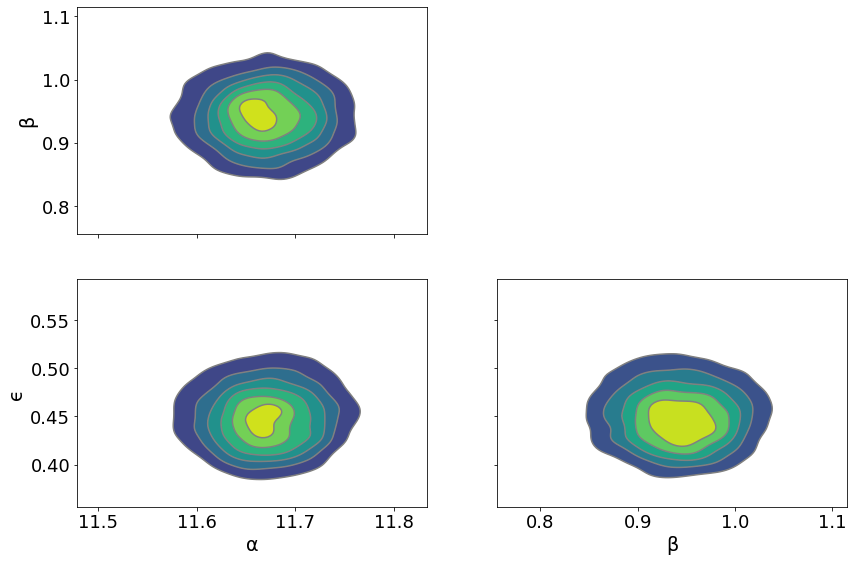

In [27]:
az.plot_pair(trace_nuts,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

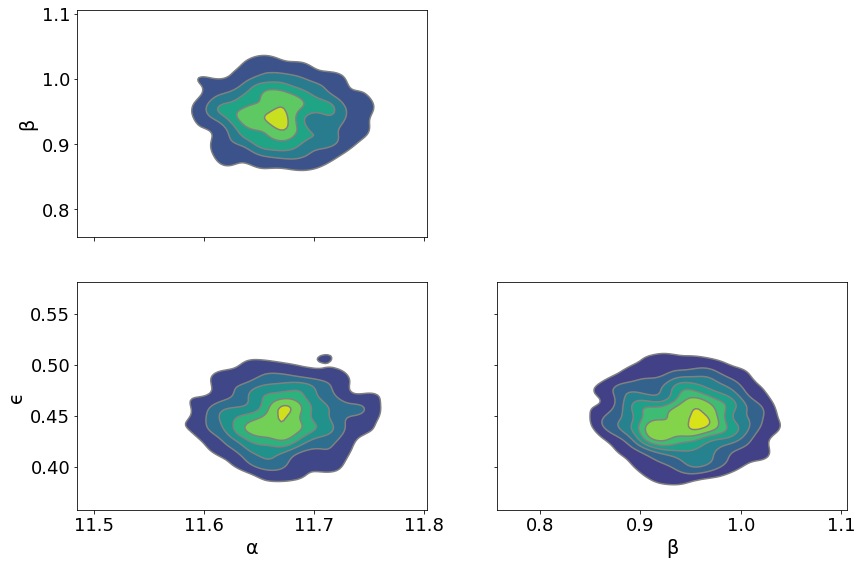

In [28]:
az.plot_pair(trace_metro,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

So Metropolis works *waaaayyyy* better when the variable is centered. 

## Exercise 7: Howell's Linear Model

1. Using the howell dataset (available at https:/​/​github.​com/​aloctavodia/​BAP) to create a linear model of the weight ( x) against the height (y). Exclude subjects that are younger than 18. Explain the results.

In [32]:
howell = pd.read_csv("../data/howell.csv", delimiter = ";")

In [36]:
howell_sub = howell[howell["age"] >= 18]

In [37]:
howell_sub.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [39]:
x = howell_sub["weight"].values
y = howell_sub["height"].values

x_centered = x - np.mean(x)

In [55]:
with pm.Model() as model_lin:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    
    x_shared = theano.shared(x_centered * 1.)
    
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_shared) #NOTE THE CHANGE!!!
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

In [56]:
with model_lin:
    trace_lin = pm.sample(2000)
    ppc_lin = pm.sample_posterior_predictive(trace_lin, samples = 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

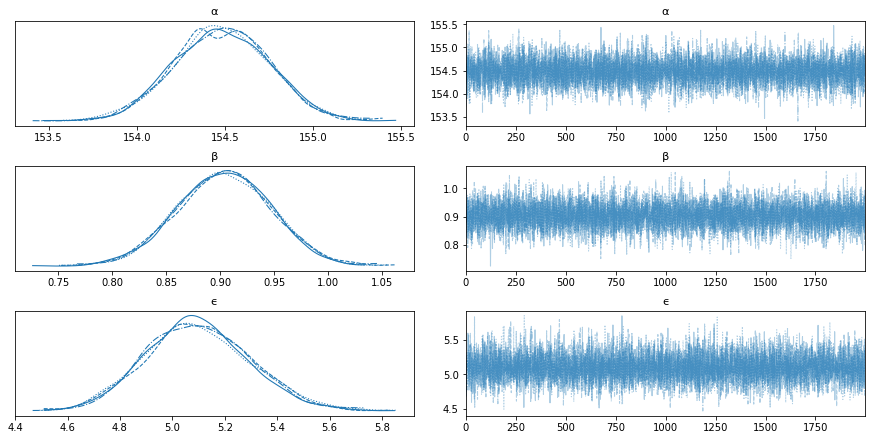

In [57]:
az.plot_trace(trace_lin, var_names = ['α', 'β', 'ϵ'])

In [60]:
az.summary(trace_lin, var_names = ['α', 'β', 'ϵ'])

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
α  154.483  0.268  153.970  154.970      0.003    0.002    9817.0   9817.0   
β    0.904  0.043    0.820    0.981      0.000    0.000   10216.0  10103.0   
ϵ    5.098  0.198    4.728    5.459      0.002    0.001    9084.0   9000.0   

   ess_bulk  ess_tail  r_hat  
α    9814.0    5747.0    1.0  
β   10221.0    5624.0    1.0  
ϵ    9167.0    5470.0    1.0

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

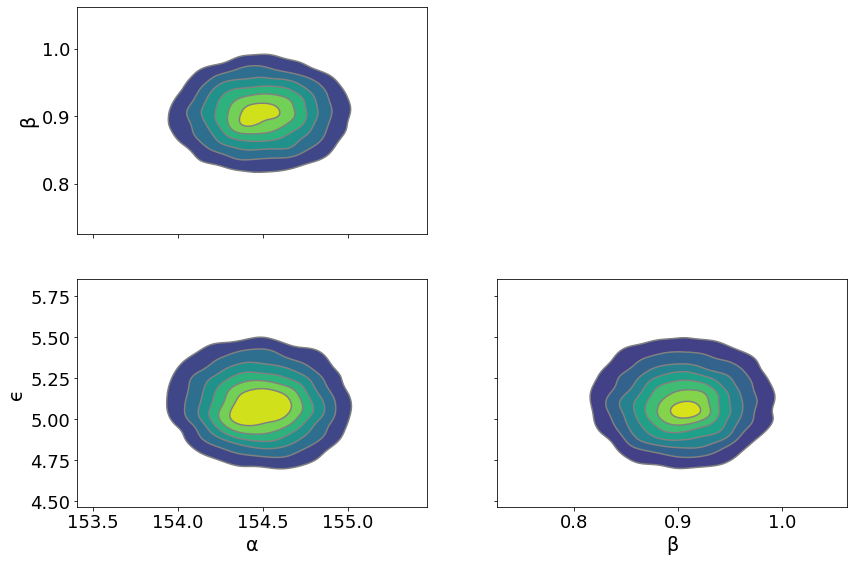

In [58]:
az.plot_pair(trace_lin,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

As we centered the variable, $\alpha$ is the mean height of the participants. $\beta$ indicates how much a unit of one gained in weight can be expected to influence height. $\epsilon$ is quite high as well, suggesting that although there is a clear effect, there is also a lot of variability between participants.

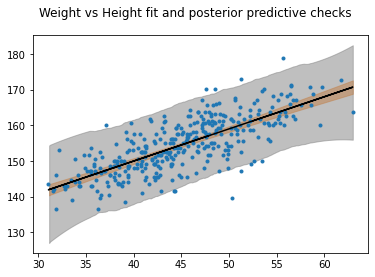

In [59]:
fig, ax = plt.subplots()

ax.plot(x, y, "C0.")
μ_m = trace_lin["μ"].mean(0)
ϵ_m = trace_lin["ϵ"].mean()

ax.plot(x, μ_m, c="k")
az.plot_hpd(x, trace_lin["μ"], hdi_prob=.98)
az.plot_hpd(x, ppc_lin["y_pred"], hdi_prob=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

## Exercise 8: The missing subjects

For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their
heights. Using the model from the previous exercise, predict the height for each
subject, together with their HPDs of 50% and 94%.
Tip1: Check coal mining disaster example in the PyMC3 documentation.
Tip2: Use shared variables

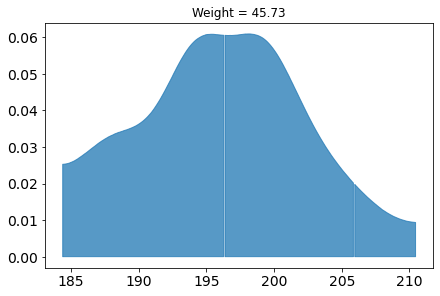

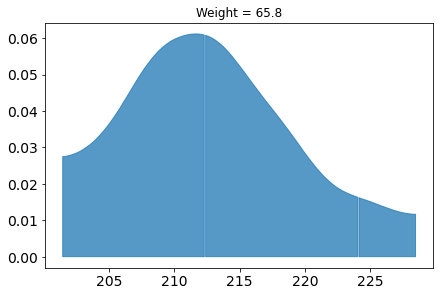

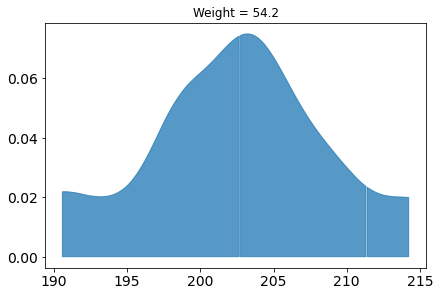

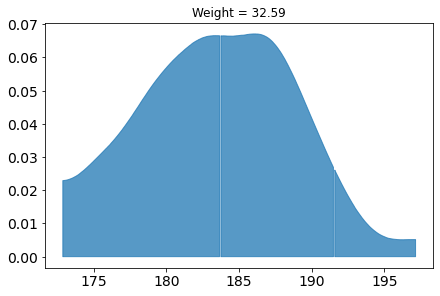

In [69]:
weights = (45.73, 65.8, 54.2, 32.59)

for i in weights:
    x_shared.set_value([i])
    ppc = pm.sample_posterior_predictive(trace_lin, samples=100, model=model_lin)
    ppc_first_col = ppc["y_pred"][:,0]
    az.plot_kde(ppc_first_col, quantiles = [.5, .94]);
    plt.title(label = f"Weight = {i}")
    plt.show() #so the different plots doesn't overlay

## Exercises 9: Teenager Troubles

In [109]:
x = howell["weight"].values
y = howell["height"].values

In [110]:
with pm.Model() as model_lin:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    
    x_shared = theano.shared(x * 1.)
    
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_shared) #NOTE THE CHANGE!!!
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

In [111]:
with model_lin:
    trace_lin = pm.sample(2000)
    ppc_lin = pm.sample_posterior_predictive(trace_lin, samples = 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

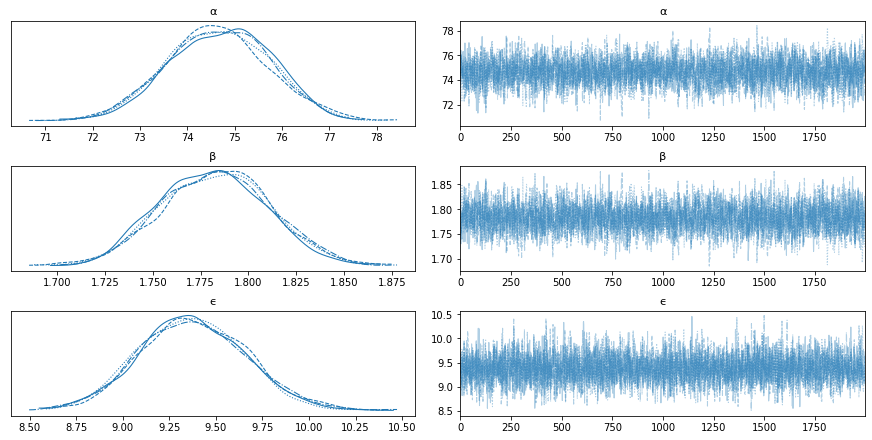

In [112]:
az.plot_trace(trace_lin, var_names = ['α', 'β', 'ϵ'])

In [113]:
az.summary(trace_lin, var_names = ['α', 'β', 'ϵ'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α  74.662  1.075  72.690   76.665      0.020    0.014    2778.0  2776.0   
β   1.783  0.028   1.730    1.834      0.001    0.000    2760.0  2760.0   
ϵ   9.378  0.286   8.831    9.904      0.004    0.003    4279.0  4256.0   

   ess_bulk  ess_tail  r_hat  
α    2754.0    3371.0    1.0  
β    2735.0    3249.0    1.0  
ϵ    4319.0    4030.0    1.0

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\plots\pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='β'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='α', ylabel='ϵ'>, <AxesSubplot:xlabel='β'>]],
      dtype=object)

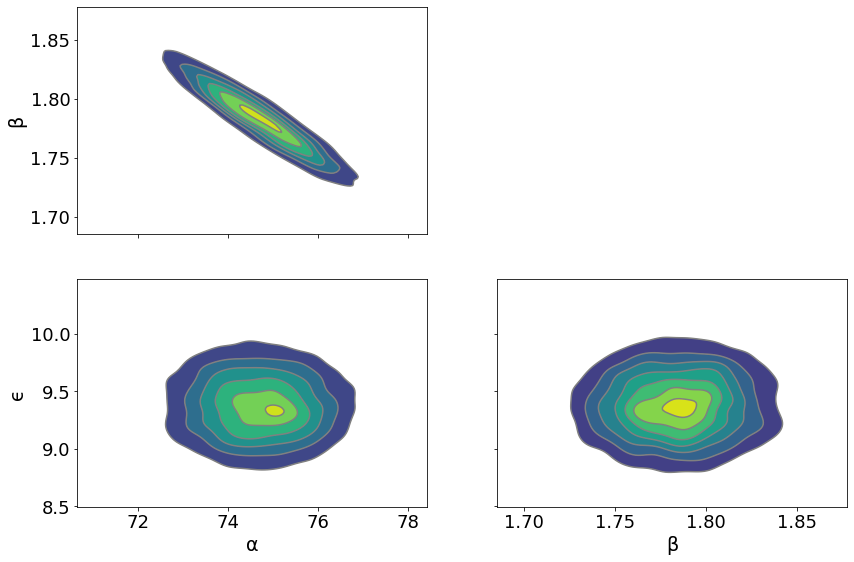

In [114]:
az.plot_pair(trace_lin,
            var_names=['α', 'β', 'ϵ'],
            kind='kde',
            divergences=True,
            textsize=18)

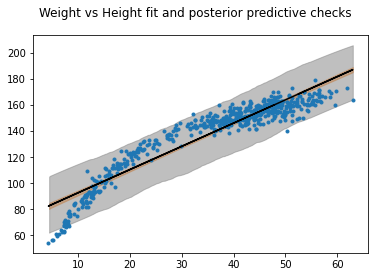

In [116]:
fig, ax = plt.subplots()

ax.plot(x, y, "C0.")
μ_m = trace_lin["μ"].mean(0)
ϵ_m = trace_lin["ϵ"].mean()

ax.plot(x, μ_m, c="k")
az.plot_hpd(x, trace_lin["μ"], hdi_prob=.98)
az.plot_hpd(x, ppc_lin["y_pred"], hdi_prob=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

Looks like it's more akin to a polynomial / logarithm.... What's the next exercise again?

## Exercise 10: Logging the logarithm

It is known for many species that the weight does not scale with the height, but
with the logarithm of the weight. Use this information to fit the howell data
(including subjects from all ages). Do one more model, this time without using
the logarithm but instead a second order polynomial. Compare and explain both
results.

_____
Note: From the above plot, it seems like the noise is varied by x. So let's model it accordingly

In [103]:
with pm.Model() as model_log:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    n = pm.HalfNormal("n", 10)
    delta = pm.HalfNormal("delta", 10)
    
    x_shared = theano.shared(x * 1.) #NOTE: Can't center it when log(), as negative values are a no-go :) 
    
    μ = pm.Deterministic('μ', α + β * theano.tensor.log(x_shared)) #NOTE THE CHANGE!!!
    ϵ = pm.Deterministic('ϵ', n + delta * x_shared)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

In [104]:
with model_log:
    trace_log = pm.sample(tune = 2000)
    ppc_log = pm.sample_posterior_predictive(trace_log, samples = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, n, β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'n'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

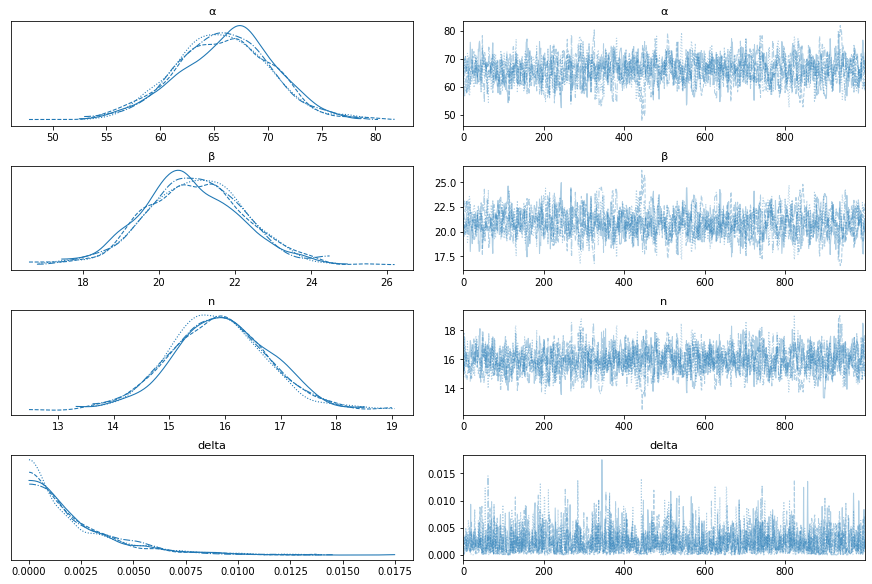

In [105]:
az.plot_trace(trace_log, var_names = ["α","β", "n", "delta"])

In [106]:
az.summary(trace_log, var_names = ["α","β", "n", "delta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α      65.902  4.543  57.049   74.132      0.154    0.109     867.0   867.0   
β      20.921  1.319  18.612   23.580      0.045    0.032     852.0   845.0   
n      15.903  0.868  14.287   17.550      0.028    0.020     970.0   970.0   
delta   0.002  0.002   0.000    0.006      0.000    0.000    2436.0  2436.0   

       ess_bulk  ess_tail  r_hat  
α         874.0    1033.0    1.0  
β         859.0    1039.0    1.0  
n         967.0    1172.0    1.0  
delta    1563.0    1129.0    1.0

In [155]:
def post_plot(x, y, trace, ppc, title, trace_param = "μ", ppc_param = "y_pred"):
    fig, ax = plt.subplots()

    ax.plot(x, y, "C0.")
    μ_m = trace[trace_param].mean(0)

    order = np.argsort(x)
    ax.plot(x[order], μ_m[order], c="k")

    az.plot_hpd(x, trace[trace_param], hdi_prob=.98)
    az.plot_hpd(x, ppc[ppc_param], hdi_prob=.98, color="gray")

    fig.suptitle(title);

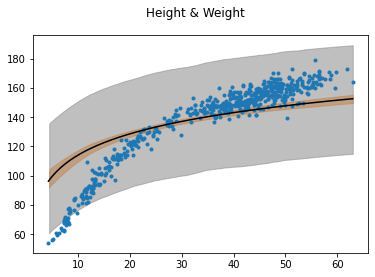

In [156]:
post_plot(x = x, y = y, trace = trace_log, ppc = ppc_log, title = "Height & Weight")

Something is not right. Seems like it is not fitting properly. Let's see if the quadratic thing works:

In [117]:
with pm.Model() as model_quad:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape = 2)
    n = pm.HalfNormal("n", 10)
    delta = pm.HalfNormal("delta", 10)
    
    x_shared = theano.shared(x * 1.) #NOTE: Can't center it when log(), as negative values are a no-go :) 
    
    μ = pm.Deterministic('μ', α + β[0] * x_shared + β[1] * x_shared**2) #NOTE THE CHANGE!!!
    ϵ = pm.Deterministic('ϵ', n + delta * x_shared)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

In [118]:
with model_quad:
    trace_quad = pm.sample(tune = 2000)
    ppc_quad = pm.sample_posterior_predictive(trace_quad, samples = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, n, β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 76 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6412295739984458, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7186852708146881, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'n'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

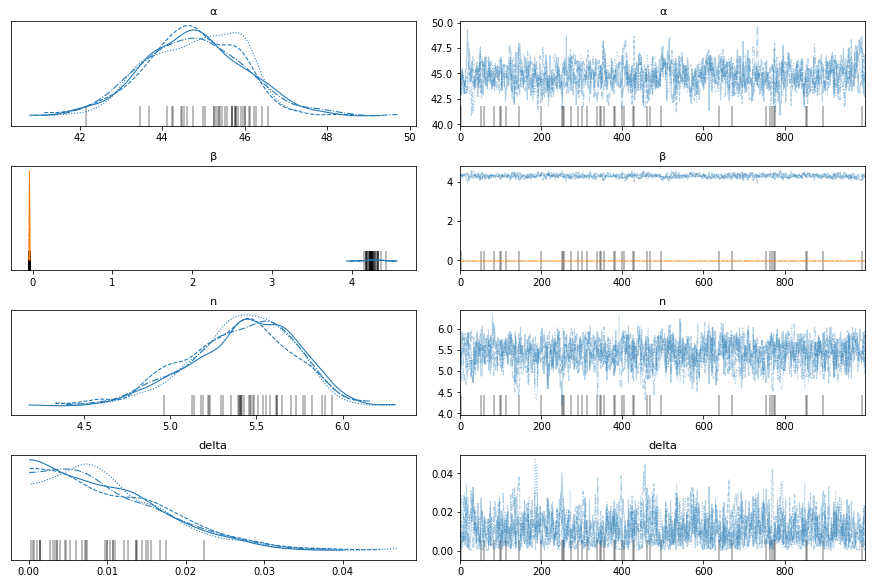

In [119]:
az.plot_trace(trace_quad, var_names = ["α","β", "n", "delta"])

In [120]:
az.summary(trace_quad, var_names = ["α","β", "n", "delta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α      44.778  1.197  42.603   46.969      0.050    0.035     571.0   571.0   
β[0]    4.283  0.089   4.132    4.456      0.004    0.003     567.0   566.0   
β[1]   -0.040  0.001  -0.042   -0.037      0.000    0.000     601.0   600.0   
n       5.412  0.303   4.822    5.918      0.011    0.008     719.0   719.0   
delta   0.011  0.008   0.000    0.024      0.000    0.000     684.0   684.0   

       ess_bulk  ess_tail  r_hat  
α         575.0     982.0   1.01  
β[0]      568.0    1048.0   1.01  
β[1]      604.0    1075.0   1.01  
n         745.0     911.0   1.00  
delta     655.0     663.0   1.00

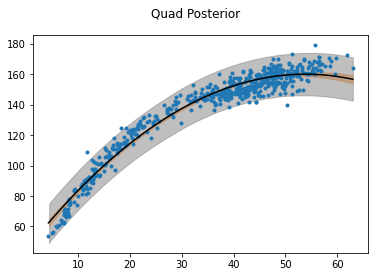

In [158]:
post_plot(x, y, trace = trace_quad, ppc = ppc_quad, title = "Quad Posterior")

Went much better. For whatever reason. 

## Exercise 11: Combing with Anscombe
Think about a model that's able to fit the three first datasets from the Anscombe
quartet. Also think about a model to fit the fourth dataset.

In [135]:
ans = pd.read_csv('../data/anscombe.csv')
ans.tail()

group     x      y
39    IV   8.0   5.25
40    IV  19.0  12.50
41    IV   8.0   5.56
42    IV   8.0   7.91
43    IV   8.0   6.89

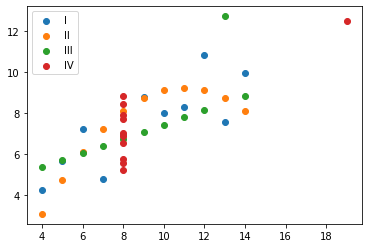

In [150]:
groupings = ("I", "II", "III", "IV")

for i in groupings:
    data = ans[ans["group"] == i]
    plt.scatter(data["x"], data["y"])
    plt.legend(groupings)
    

Remember that linear regression is a special case of polynomial regression. I think a polynomial regression with quadratic would be good call for all of this. You might want to include something like a "Student T" for doing some this stuff because of the outliers, but who knows. 